In [1]:
import matplotlib.pyplot as plt

In [2]:
from visuals import *

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [525]:
def eigenvalues_plot(x_acc_clear,n = 10):   
    HM = hankel_matrix(x_acc_clear.values.reshape([-1,1]), n)

    S = np.linalg.svd(HM,compute_uv=False)

    plt.figure(figsize=(11, 6))

    plt.plot(S**.5,'.')
    plt.plot(S**.5,'--')

    #plt.xlim(-1,20)


    plt.xlabel('N', size=23)
    plt.ylabel('λ', size=23)

    plt.tick_params(axis='both', which='major', labelsize=25,length=8, width=4)
    plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.8)
    plt.minorticks_on()
    plt.grid(which='minor', 
        color = 'gray', 
        linestyle = '--',
        linewidth = 0.5)
    plt.legend(shadow=True, ncol=1, fontsize=15)
    plt.show()

def integ(xs,ys):
    Y = []
    X = []
    temp_y = 0.0
    temp_x = 0.0
    for i in range(len(xs)-1):
        temp_x = (xs[i+1]+xs[i])/2
        X.append(temp_x)

        temp_y += (xs[i+1]-xs[i])*(ys[i+1]+ys[i])/2
        Y.append(temp_y)
    return np.array(X),np.array(Y)

def diff(x,y):
    h = x[1]-x[0]
    y0 = (-3*y[0]+4*y[1]-y[2])/(2*h)
    y1 = (y[2:]-y[:-2])/(2*h)
    y2 = (y[-3]-4*y[-2]+3*y[-1])/(2*h)
    return np.concatenate(([y0],y1,[y2]))

def Sphere_projection(track, n = 1):
    
    _x = track2[:,0] - track2[:,0].mean()
    _y = track2[:,1] - track2[:,1].mean()
    _z = track2[:,2] - track2[:,2].mean()
    
    track = np.array([_x,_y,_z]).T
    
    
    for i in range(len(track)):
        track[i] = track[i]/((track[i,:]**2).sum())**.5

    t, p = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]

    x_s = 0.9*np.sin(t)*np.cos(p)
    y_s = 0.9*np.sin(t)*np.sin(p)
    z_s = 0.9*np.cos(t)

    fig_2 = go.Figure()

    fig_2.add_trace(go.Surface(x=x_s,
                               y=y_s,
                               z=z_s,
                               showscale=False,
                               surfacecolor = z_s))

    fig_2.add_trace(go.Scatter3d(x=track[:,0][::n], 
                                 y=track[:,1][::n],
                                 z=track[:,2][::n], 
                                 #mode='markers',
                                 marker=dict(
                                             size=2,
                                             line=dict(
                                                        width=0.1
                                                      )

                                             ),
                                 name='trajectory'
                                )
                    )
    fig_2.add_trace(go.Scatter3d(x=[track[0, 0]],
                               y=[track[0, 1]],
                               z=[track[0, 2]],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(255, 10, 0, .7)',
                               name='Start point'))

    fig_2.add_trace(go.Scatter3d(x=[track[-1, 0]],
                               y=[track[-1, 1]],
                               z=[track[-1, 2]],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(10, 250, 250, .7)',
                               name='End point'))

    fig_2.layout.template = 'plotly_white'
    fig_2.show()

    return

def hankel_matrix(series, l):

    HM = np.zeros([series.shape[0] - l, l])

    for i in range(0, series.shape[0] - l):
        HM[i] = np.squeeze(series[i:i + l, 0])
    return HM

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [497]:
#data = pd.read_csv('data/test2_acc.csv', delimiter =';', decimal=',')[249:-201]

In [577]:
data = pd.read_csv('data/home_1_accm.csv', delimiter =';', decimal=',')[5000:7400]

In [578]:
data.head();
len(data)

2400

In [579]:
x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5


In [580]:
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

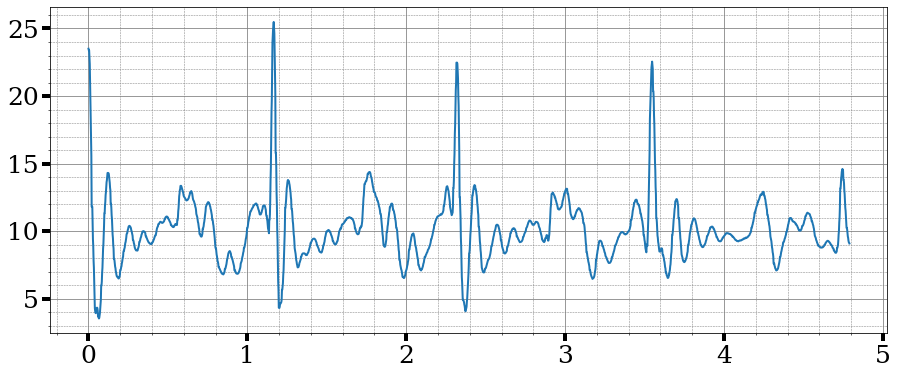

In [581]:
plt.figure(figsize=(15, 6))
plt.plot(t[:],x_acc[:])
plt.tick_params(axis='both', which='major', labelsize=25,length=8, width=4)
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

In [582]:
len(t)

2400

In [589]:
p = int(len(t)/4)-10

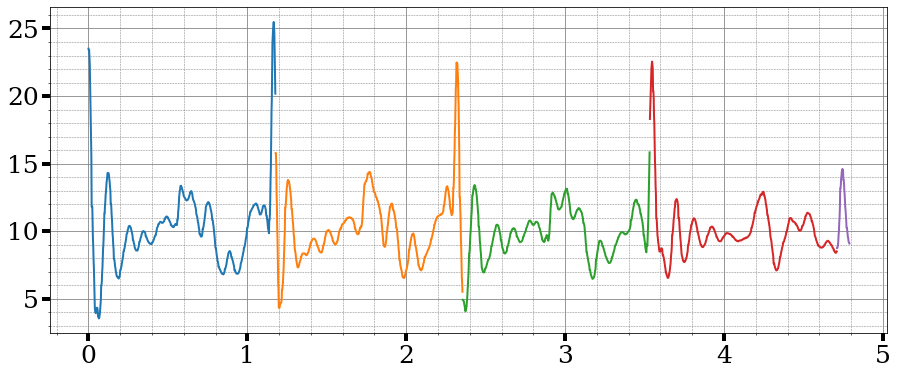

In [590]:
plt.figure(figsize=(15, 6))

for i in range(16):

    plt.plot(t[i*p:(i+1)*p],x_acc[i*p:(i+1)*p])
    
plt.tick_params(axis='both', which='major', labelsize=25,length=8, width=4)
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

In [503]:
fig = go.Figure()
fig.add_scatter(x = t, y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [601]:
accel_ssa = SSA(x_acc, 600)

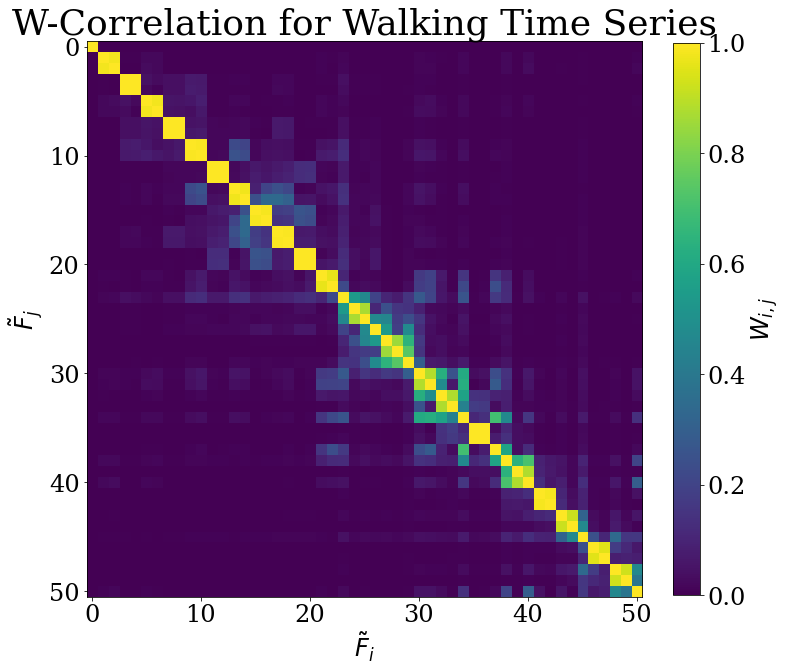

In [602]:
plt.figure(figsize=(11, 11))
accel_ssa.plot_wcorr(max=50)
plt.title("W-Correlation for Walking Time Series");

In [507]:
slice(2,4)

slice(2, 4, None)

In [594]:
fig = go.Figure()
fig.add_scatter(x = t[:], y = x_acc[:], mode='lines', name='Real')
fig.add_scatter(x = t[:], y = accel_ssa.reconstruct(slice(10,20))[:], mode='lines', name='slice')
#fig.add_scatter(x = t, y = accel_ssa.reconstruct(slice(100,200)), mode='lines', name='slice(100,200)')
#fig.add_scatter(x = t, y = accel_ssa.reconstruct(slice(200,400)), mode='lines', name='slice(200,400)')
fig.show()

In [548]:
fig = go.Figure()
fig.add_scatter(x = t[:], y = x_acc[:], mode='lines', name='Real')
#fig.add_scatter(x = t[:], y = accel_ssa.reconstruct(slice(7,16))[:], mode='lines', name='slice')
for i in range(10):
    fig.add_scatter(x = t, y = accel_ssa.reconstruct(slice(i)), mode='lines', name=str(i))
#fig.add_scatter(x = t, y = accel_ssa.reconstruct(slice(200,400)), mode='lines', name='slice(200,400)')
fig.show()

fig_v = go.Figure()
temp = integ(t,np.array(accel_ssa.reconstruct(slice(2,4))))
fig_v.add_scatter(x = temp[0], y = temp[1], mode='lines', name='Velocity')
fig_v.show()

fig_a = go.Figure()
fig_a.add_scatter(x = temp[0], y = diff(temp[0],temp[1]), mode='lines', name='Velocity')
fig_a.add_scatter(x = t, y = accel_ssa.reconstruct(slice(1,4)), mode='lines', name='slice(0,3)')
fig_a.show()

In [595]:
x_acc_clear = accel_ssa.reconstruct(slice(10,20))

track1, basis1 = phase_track(x_acc_clear.values.reshape([-1,1]), 400, 2)

plot_phase_track(track1[:])

Explained variation for 2 principal components: [0.14908035 0.1477661 ]
Cumulative explained variationfor 2 principal components: 0.29684645173997476



In [596]:
track2, basis2 = phase_track(x_acc_clear.values.reshape([-1,1]), 400, 3)

Explained variation for 3 principal components: [0.14908035 0.1477661  0.12663292]
Cumulative explained variationfor 3 principal components: 0.4234793736263556



In [597]:
plot_phase_track(track2)

In [598]:
Sphere_projection(track2, n = 1)

No handles with labels found to put in legend.


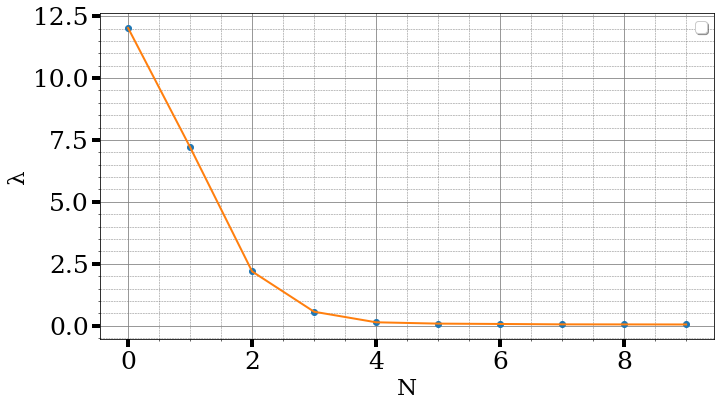

In [599]:
eigenvalues_plot(accel_ssa.reconstruct(slice(10,20)))

No handles with labels found to put in legend.


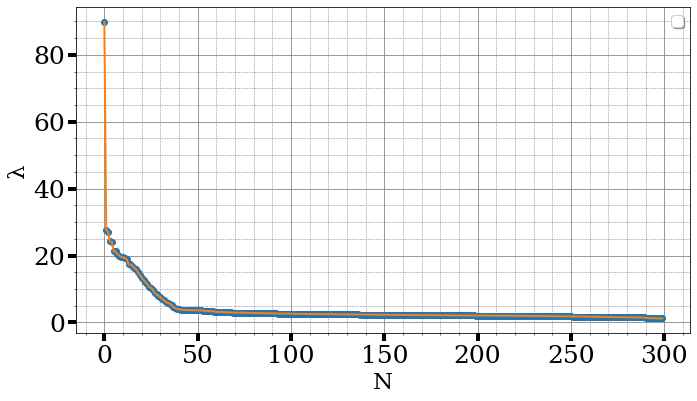

In [593]:
eigenvalues_plot(pd.Series(x_acc),n=300)